<a href="https://colab.research.google.com/github/cdmdc/lr-identify-custom/blob/main/NeuralData_LearningRulesClassifier_cdmdc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/cdmdc/lr-identify-custom
%cd lr-identify

Cloning into 'lr-identify'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 64 (delta 21), reused 40 (delta 8), pack-reused 0
Unpacking objects: 100% (64/64), done.
/content/lr-identify


In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io as spio

In [ ]:
#Load Camille obs stats 
with open('/content/obs_stats.npy', 'rb') as f:
    obs_stats = np.load(f)

print(np.shape(obs_stats))

(448, 21, 42)


In [ ]:
!bash get_dataset.sh
data = pickle.load(open('dataset.pkl', 'rb'), encoding='latin1')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  511M  100  511M    0     0  18.7M      0  0:00:27  0:00:27 --:--:-- 20.6M


In [ ]:
print(data['X'].shape)
print(data['X_cat'].shape)
print(data['Y'].shape)
print(np.unique(data['Y']))
print(data['obs_keys'])
print(data['meta'])
print('Architectures: {} \n'.format(np.unique(data['meta']['architecture'])))
print('Tasks: {}'.format(np.unique(data['meta']['task'])))

(20736, 21, 45)
(20736, 21, 3)
(20736,)
['adam' 'feedback' 'information' 'sgdm']
['weightabs_kurtosis' 'weightabs_mean' 'weightabs_median' 'weightabs_norm'
 'weightabs_skew' 'weightabs_thirdquartile' 'weightabs_var'
 'weightraw_kurtosis' 'weightraw_mean' 'weightraw_median' 'weightraw_norm'
 'weightraw_skew' 'weightraw_thirdquartile' 'weightraw_var'
 'weightsq_kurtosis' 'weightsq_mean' 'weightsq_median' 'weightsq_norm'
 'weightsq_skew' 'weightsq_thirdquartile' 'weightsq_var' 'actabs_kurtosis'
 'actabs_mean' 'actabs_median' 'actabs_norm' 'actabs_skew'
 'actabs_thirdquartile' 'actabs_var' 'actraw_kurtosis' 'actraw_mean'
 'actraw_median' 'actraw_norm' 'actraw_skew' 'actraw_thirdquartile'
 'actraw_var' 'actsq_kurtosis' 'actsq_mean' 'actsq_median' 'actsq_norm'
 'actsq_skew' 'actsq_thirdquartile' 'actsq_var' 'gradavgabs_id'
 'gradavgraw_id' 'gradavgsq_id']
[('imagenet', 0, 'adam', None, 21, 0, 'resnet18', 256, 'block_group1_0/conv2')
 ('imagenet', 0, 'adam', None, 21, 0, 'resnet18', 256, 'blo

In [ ]:
print(type(data))
print(data['meta'][0])
print(data['meta']['model_seed'])
print(data['meta'].dtype)
print(np.shape(data['meta']))
print(np.shape(data['obs_keys']))
print(np.shape(data['Y']))
print(np.shape(data['obs_keys']))
print(type(data['X_cat']))
print(data['X_cat'][20000,0,:])
print(np.unique(data['meta']['learning_rule']))

<class 'dict'>
('imagenet', 0, 'adam', None, 21, 0, 'resnet18', 256, 'block_group1_0/conv2')
[0 0 0 ... None None None]
(numpy.record, [('task', '<U8'), ('start_idxs', '<i8'), ('learning_rule', '<U11'), ('dataset_seed', 'O'), ('end_idxs', '<i8'), ('model_seed', 'O'), ('architecture', '<U10'), ('batch_size', '<i8'), ('layer_name', '<U21')])
(20736,)
(45,)
(20736,)
(45,)
<class 'numpy.ndarray'>
[0 0 1]
['adam' 'feedback' 'information' 'sgdm']


In [ ]:
#Define new dict and copy over unchanged settings
data_modified = {}
data_modified['obs_keys'] = data['obs_keys']
meta_entry_neural_data = ('neural', 0, 'unknown', None, 21, 0, 'curbd', 256, '')

num_trials = 448#123
num_samples = 21
num_obs_stats = 42

# Get meta data and append new meta data
data_meta_list = data['meta']
print(type(data_meta_list))
print(np.shape(data_meta_list))
data_meta_list = data_meta_list.tolist()
print(type(data_meta_list))
print(np.shape(data_meta_list))
print(data_meta_list)

for samples in range(num_trials):
  data_meta_list.append(meta_entry_neural_data)
print(np.shape(data_meta_list))

#Convert back to recarray and put into data_modified
data_meta_recarray = np.array(data_meta_list,dtype=[('task', '<U8'), ('start_idxs', '<i8'), ('learning_rule', '<U11'), ('dataset_seed', 'O'), ('end_idxs', '<i8'), ('model_seed', 'O'), ('architecture', '<U10'), ('batch_size', '<i8'), ('layer_name', '<U21')])
data_meta_recarray = data_meta_recarray.view(np.recarray)
print(type(data_meta_recarray))
print(np.shape(data_meta_recarray))
data_modified['meta'] = data_meta_recarray

#Get data and reduce to relevant dims. Append new data from curbd
data_X  = data['X'][:,:,:num_obs_stats]
data_X = np.concatenate((data_X,obs_stats),axis=0)
print(np.shape(data_X))
data_modified['X'] = data_X

#Get Y labels and append new labels
data_Y = data['Y']
print(type(data_Y))
print(np.shape(data_Y))
data_Y = data_Y.tolist()
for samples in range(num_trials):
  data_Y.append('unknown')
print(np.shape(data_Y))
data_modified['Y'] = np.array(data_Y)

#Get X_cat (layer position) variable and append [1,0,0]
X_cat = data['X_cat']
print(np.shape(X_cat))
X_cat_curbd = np.tile([1,0,0],(np.shape(obs_stats)[0],np.shape(obs_stats)[1],1))
print(np.shape(X_cat_curbd))
data_modified['X_cat'] = np.concatenate((X_cat,X_cat_curbd),axis=0)
print(np.shape(data_modified['X_cat']))

<class 'numpy.recarray'>
(20736,)
<class 'list'>
(20736, 9)
[('imagenet', 0, 'adam', None, 21, 0, 'resnet18', 256, 'block_group1_0/conv2'), ('imagenet', 0, 'adam', None, 21, 0, 'resnet18', 256, 'block_group1_0/conv0'), ('imagenet', 0, 'adam', None, 21, 0, 'resnet18', 256, 'block_group1_0/conv1'), ('imagenet', 0, 'adam', None, 21, 0, 'resnet18', 256, 'block_group3_1/conv1'), ('imagenet', 0, 'adam', None, 21, 0, 'resnet18', 256, 'block_group3_1/conv2'), ('imagenet', 0, 'adam', None, 21, 0, 'resnet18', 256, 'block_group2_1/conv1'), ('imagenet', 0, 'adam', None, 21, 0, 'resnet18', 256, 'block_group2_1/conv2'), ('imagenet', 0, 'adam', None, 21, 0, 'resnet18', 256, 'dense'), ('imagenet', 0, 'adam', None, 21, 0, 'resnet18', 256, 'block_group4_0/conv2'), ('imagenet', 0, 'adam', None, 21, 0, 'resnet18', 256, 'block_group4_0/conv1'), ('imagenet', 0, 'adam', None, 21, 0, 'resnet18', 256, 'block_group4_0/conv0'), ('imagenet', 0, 'adam', None, 21, 0, 'resnet18', 256, 'conv0'), ('imagenet', 0, 'adam

In [ ]:
#Double check variable indexing works
print(data_modified['meta']['learning_rule'])
print(data_modified['meta']['task'])

['adam' 'adam' 'adam' ... 'unknown' 'unknown' 'unknown']
['imagenet' 'imagenet' 'imagenet' ... 'neural' 'neural' 'neural']


In [ ]:
learning_rules = ['adam', 'sgdm', 'information', 'feedback','unknown']
task_filter = ['imagenet','audionet','cifar10','simclr','neural']
# cls_filter = lambda x: (x['learning_rule'] in learning_rules) and (x['task'] in task_filter)
cls_filter = lambda x: (x['learning_rule'] in learning_rules[:-1]) and (x['task'] in task_filter[:-1])
# cls_filter = lambda x: (x['learning_rule'] in learning_rules[:-1]) and (x['task'] == 'imagenet')

In [ ]:
from cross_validation import get_possible_inds

cls_filter_train = lambda x: (x['learning_rule'] == learning_rules[0]) and (x['task'] in task_filter[:-1])
# cls_filter_train = lambda x: (x['learning_rule'] == learning_rules[0]) and (x['task'] == 'imagenet')
cls_filter_first_lr_indices = get_possible_inds(data_modified['meta'], cls_filter_train)
num_total_per_class = len(cls_filter_first_lr_indices)
num_total_examples =  num_total_per_class * len(learning_rules)
print(num_total_per_class)

#sanity check for category balanced data
# assert(num_total_examples == len(get_possible_inds(data_modified['meta'], cls_filter)))

#now we compute num per class train and test
train_frac = 0.8
num_per_class_train = (int)(np.ceil(train_frac*num_total_per_class))

print(num_per_class_train)
print(cls_filter_first_lr_indices)
print(type(cls_filter_first_lr_indices))

# num_per_class_train = 20736
# cls_filter_indices_train = np.arange(0,20736)
# print(num_per_class_train)
# print(cls_filter_indices_train)


5184
4148
[    0     1     2 ... 20709 20710 20711]
<class 'numpy.ndarray'>


In [ ]:
#Get test indices for neural data
cls_filter_test = lambda x: (x['learning_rule'] == 'unknown') and (x['task'] == 'neural')
#cls_filter_test = cls_filter
cls_filter_first_lr_indices_test = get_possible_inds(data_modified['meta'], cls_filter_test)
num_per_class_test = len(cls_filter_first_lr_indices_test)
#num_per_class_test = num_total_per_class-num_per_class_train
print(num_per_class_test)
print(cls_filter_first_lr_indices_test)

# num_entries_data = data['X'].shape[0]
# num_per_class_test = num_entries_data - num_per_class_train
# cls_filter_indices_test = np.arange(20736,num_entries_data)
# print(num_per_class_test)
# print(cls_filter_indices_test)

448
[20736 20737 20738 20739 20740 20741 20742 20743 20744 20745 20746 20747
 20748 20749 20750 20751 20752 20753 20754 20755 20756 20757 20758 20759
 20760 20761 20762 20763 20764 20765 20766 20767 20768 20769 20770 20771
 20772 20773 20774 20775 20776 20777 20778 20779 20780 20781 20782 20783
 20784 20785 20786 20787 20788 20789 20790 20791 20792 20793 20794 20795
 20796 20797 20798 20799 20800 20801 20802 20803 20804 20805 20806 20807
 20808 20809 20810 20811 20812 20813 20814 20815 20816 20817 20818 20819
 20820 20821 20822 20823 20824 20825 20826 20827 20828 20829 20830 20831
 20832 20833 20834 20835 20836 20837 20838 20839 20840 20841 20842 20843
 20844 20845 20846 20847 20848 20849 20850 20851 20852 20853 20854 20855
 20856 20857 20858 20859 20860 20861 20862 20863 20864 20865 20866 20867
 20868 20869 20870 20871 20872 20873 20874 20875 20876 20877 20878 20879
 20880 20881 20882 20883 20884 20885 20886 20887 20888 20889 20890 20891
 20892 20893 20894 20895 20896 20897 20898 2089

In [ ]:
from fit_pipeline import PipelineClassifier
from functools import partial
from fit_pipeline import ObsClassifier

classifier_type = partial(PipelineClassifier, estimators=[('cls', 'randomforest')])
cv_param_grid = {'cls__max_features': ['sqrt', 'log2'], 'cls__n_estimators': [20, 50]}

In [ ]:
#Run Classification based on 'all' (act and weights)
cls_out_all = ObsClassifier(
                classifier_type=classifier_type, # 'randomforest' in this case
                num_splits=10, # number of train/test splits
                num_per_class_train=num_per_class_train, # how many examples per category to train on
                num_per_class_test=num_per_class_test, # how many examples per category to test on
                train_filter=cls_filter, # the subset of data we want to train on
                test_filter=cls_filter_test, # the subset of data we want to test on
                data=data_modified, # the raw data
                cls_dataset_transform_kwargs={'obs_measure': 'all', 'num_dims': 2}, # train on activations observable measure, flattening trajectories
                cv_param_grid=cv_param_grid, # cross validation search space
                verbose=True)

Will be running cross val and returning results.
Score: 0.9698704429044893. Num train examples: 13273. Num val examples: 3319
Score: 0.7770412774932208. Num train examples: 13273. Num val examples: 3319
Score: 0.9553948161543099. Num train examples: 13274. Num val examples: 3318
Score: 0.9620253164556962. Num train examples: 13274. Num val examples: 3318
Score: 0.8809523809523809. Num train examples: 13274. Num val examples: 3318
Score: 0.9761976498945466. Num train examples: 13273. Num val examples: 3319
Score: 0.7966254896053028. Num train examples: 13273. Num val examples: 3319
Score: 0.9641350210970464. Num train examples: 13274. Num val examples: 3318
Score: 0.9638336347197106. Num train examples: 13274. Num val examples: 3318
Score: 0.8734177215189873. Num train examples: 13274. Num val examples: 3318
Score: 0.9731846941849955. Num train examples: 13273. Num val examples: 3319
Score: 0.7667972280807472. Num train examples: 13273. Num val examples: 3319
Score: 0.9559975889089813. 

/content/lr-identify/metrics.py:99: RuntimeWarning: invalid value encountered in true_divide
  TPR = TP / P.astype(float)
/content/lr-identify/metrics.py:100: RuntimeWarning: invalid value encountered in true_divide
  FPR = FP / N.astype(float)
/content/lr-identify/metrics.py:89: RuntimeWarning: invalid value encountered in true_divide
  sensitivity = TP / P.astype(float)
/content/lr-identify/metrics.py:90: RuntimeWarning: invalid value encountered in true_divide
  specificity = TN / N.astype(float)
/content/lr-identify/metrics.py:107: RuntimeWarning: invalid value encountered in double_scalars
  return correct / float(total)
/content/lr-identify/metrics.py:107: RuntimeWarning: invalid value encountered in true_divide
  return correct / float(total)


In [ ]:
print('Number test cases:',np.shape(cls_out_all.results['test']['predictions']))
print('Predicted test labels:',cls_out_all.results['test']['predictions'])
print('Labels available:',cls_out_all.results['test']['labels'])
print('Unique Label IDs:',np.unique(cls_out_all.results['train']['predictions']))
print('Train Accuracy by split:',cls_out_all.results['train']['accuracy_by_split'])
print('Train Accuracy Mean:',cls_out_all.results['train']['mean_accuracy'])

Number test cases: (448,)
Predicted test labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Labels available: ['adam' 'sgdm' 'informa

In [ ]:
#Run Classification based on activity ('act')
cls_out_act = ObsClassifier(
                classifier_type=classifier_type, # 'randomforest' in this case
                num_splits=10, # number of train/test splits
                num_per_class_train=num_per_class_train, # how many examples per category to train on
                num_per_class_test=num_per_class_test, # how many examples per category to test on
                train_filter=cls_filter, # the subset of data we want to train on
                test_filter=cls_filter_test, # the subset of data we want to test on
                data=data_modified, # the raw data
                cls_dataset_transform_kwargs={'obs_measure': 'act', 'num_dims': 2}, # train on activations observable measure, flattening trajectories
                cv_param_grid=cv_param_grid, # cross validation search space
                verbose=True)

Will be running cross val and returning results.
Score: 0.8044591744501356. Num train examples: 13273. Num val examples: 3319
Score: 0.7243145525760771. Num train examples: 13273. Num val examples: 3319
Score: 0.7848101265822784. Num train examples: 13274. Num val examples: 3318
Score: 0.8860759493670886. Num train examples: 13274. Num val examples: 3318
Score: 0.8239903556359253. Num train examples: 13274. Num val examples: 3318
Score: 0.8210304308526665. Num train examples: 13273. Num val examples: 3319
Score: 0.7173847544441097. Num train examples: 13273. Num val examples: 3319
Score: 0.807715491259795. Num train examples: 13274. Num val examples: 3318
Score: 0.9017480409885473. Num train examples: 13274. Num val examples: 3318
Score: 0.8155515370705244. Num train examples: 13274. Num val examples: 3318
Score: 0.8210304308526665. Num train examples: 13273. Num val examples: 3319
Score: 0.7312443507080446. Num train examples: 13273. Num val examples: 3319
Score: 0.7941531042796866. N

/content/lr-identify/metrics.py:99: RuntimeWarning: invalid value encountered in true_divide
  TPR = TP / P.astype(float)
/content/lr-identify/metrics.py:100: RuntimeWarning: invalid value encountered in true_divide
  FPR = FP / N.astype(float)
/content/lr-identify/metrics.py:89: RuntimeWarning: invalid value encountered in true_divide
  sensitivity = TP / P.astype(float)
/content/lr-identify/metrics.py:90: RuntimeWarning: invalid value encountered in true_divide
  specificity = TN / N.astype(float)
/content/lr-identify/metrics.py:107: RuntimeWarning: invalid value encountered in double_scalars
  return correct / float(total)
/content/lr-identify/metrics.py:107: RuntimeWarning: invalid value encountered in true_divide
  return correct / float(total)


In [ ]:
print('Number test cases:',np.shape(cls_out_act.results['test']['predictions']))
print('Predicted test labels:',cls_out_act.results['test']['predictions'])
print('Labels available:',cls_out_act.results['test']['labels'])
print('Unique Label IDs:',np.unique(cls_out_act.results['train']['predictions']))
print('Train Accuracy by split:',cls_out_act.results['train']['accuracy_by_split'])
print('Train Accuracy Mean:',cls_out_act.results['train']['mean_accuracy'])
print('Test mean dprime:',cls_out_act.results['test']['mean_dprime'])

Number test cases: (448,)
Predicted test labels: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2]
Labels available: ['adam' 'sgdm' 'informa

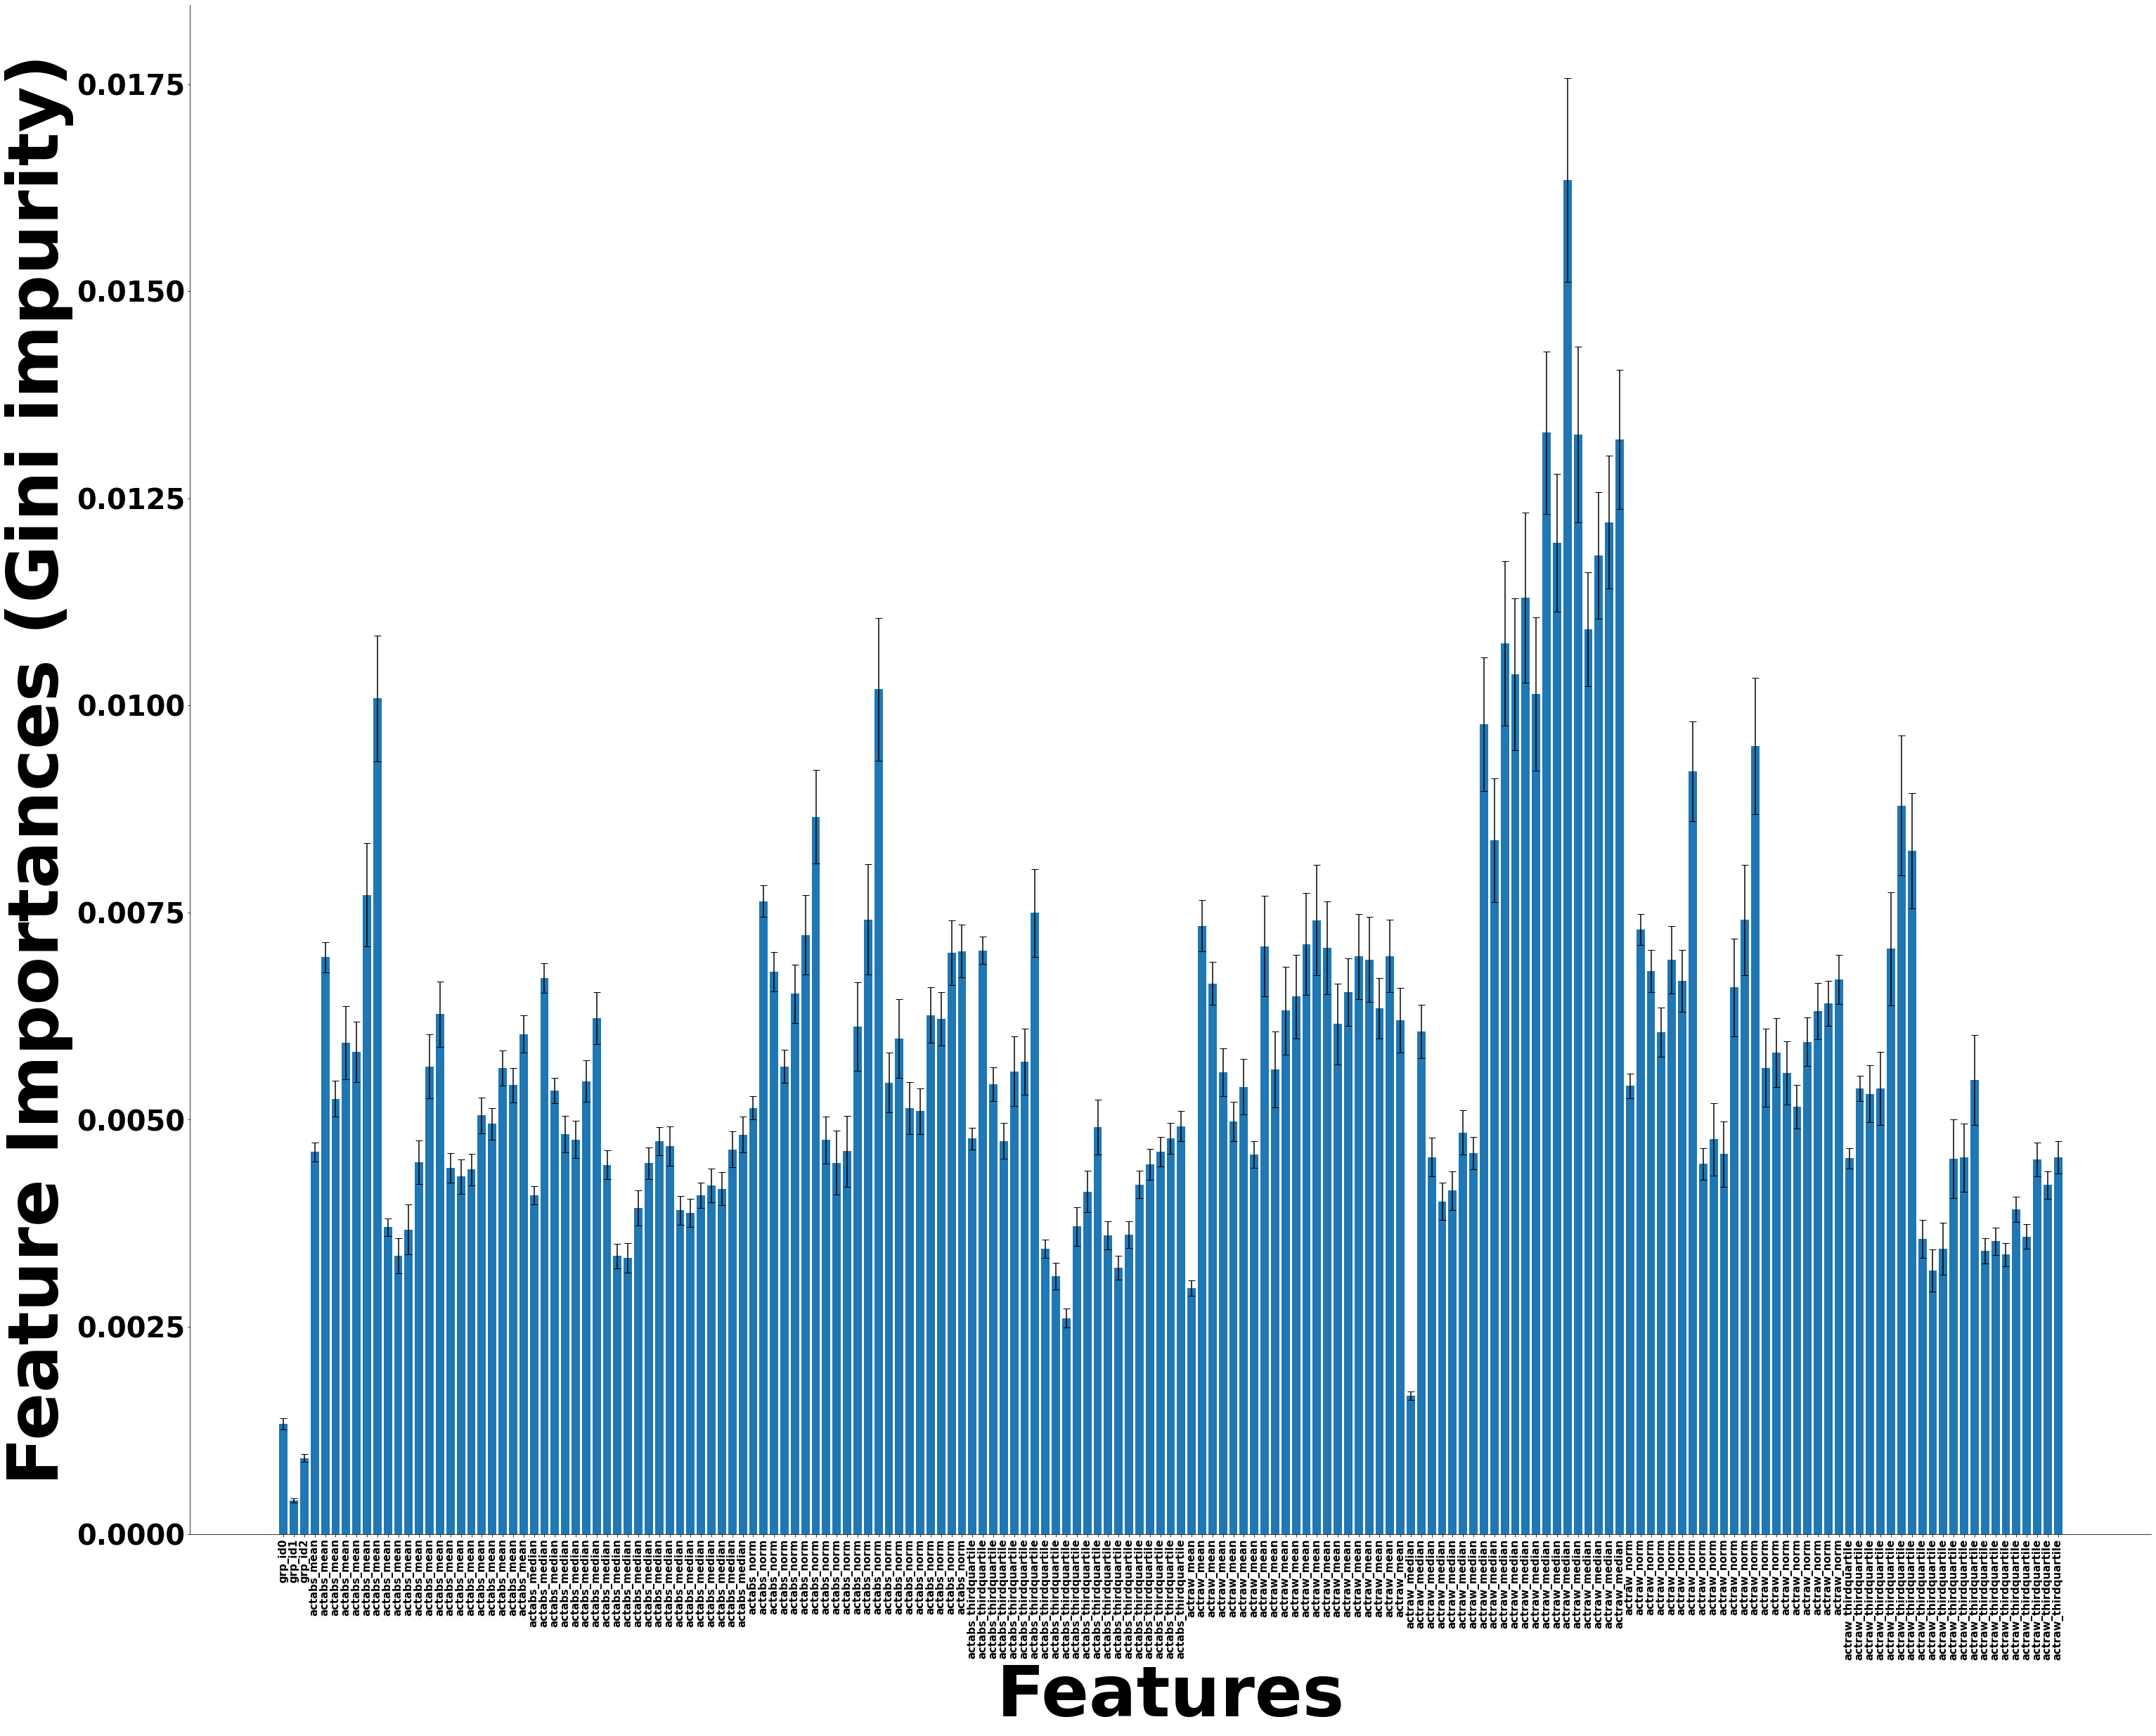

In [ ]:
from scipy.stats import sem

fig = plt.figure(figsize=(50, 40))

trajectory_len = data['X'].shape[1]
observable_trajectory_names = list(cls_out_act.results['feature_names'][:3]) \
                             + list(np.repeat(cls_out_act.results['feature_names'][3:], trajectory_len))
x = np.arange(len(observable_trajectory_names))
feat_importances = np.row_stack(cls_out_act.results['feature_importances_by_split'])
plt.bar(x, 
        np.mean(feat_importances, axis=0),
        yerr=sem(feat_importances, axis=0),
        capsize=5)
plt.xticks(x, observable_trajectory_names, rotation=90, 
           fontsize=15, fontweight='bold')
plt.yticks(fontsize=40, fontweight='bold')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('Features', fontsize=100, fontweight='bold')
plt.ylabel('Feature Importances (Gini impurity)', fontsize=100, fontweight='bold')
plt.show()

In [ ]:
#Run Classification based on weights ('weight')
cls_out_weights = ObsClassifier(
                classifier_type=classifier_type, # 'randomforest' in this case
                num_splits=10, # number of train/test splits
                num_per_class_train=num_per_class_train, # how many examples per category to train on
                num_per_class_test=num_per_class_test, # how many examples per category to test on
                train_filter=cls_filter, # the subset of data we want to train on
                test_filter=cls_filter_test, # the subset of data we want to test on
                data=data_modified, # the raw data
                cls_dataset_transform_kwargs={'obs_measure': 'weight', 'num_dims': 2}, # train on activations observable measure, flattening trajectories
                cv_param_grid=cv_param_grid, # cross validation search space
                verbose=True)

Will be running cross val and returning results.
Score: 0.9683639650497138. Num train examples: 13273. Num val examples: 3319
Score: 0.7559505875263633. Num train examples: 13273. Num val examples: 3319
Score: 0.9110910186859554. Num train examples: 13274. Num val examples: 3318
Score: 0.9614225437010248. Num train examples: 13274. Num val examples: 3318
Score: 0.8746232670283303. Num train examples: 13274. Num val examples: 3318
Score: 0.9602289846339259. Num train examples: 13273. Num val examples: 3319
Score: 0.7517324495329919. Num train examples: 13273. Num val examples: 3319
Score: 0.9463532248342374. Num train examples: 13274. Num val examples: 3318
Score: 0.958710066305003. Num train examples: 13274. Num val examples: 3318
Score: 0.8601567209162145. Num train examples: 13274. Num val examples: 3318
Score: 0.9695691473335342. Num train examples: 13273. Num val examples: 3319
Score: 0.7517324495329919. Num train examples: 13273. Num val examples: 3319
Score: 0.9415310427968656. N

/content/lr-identify/metrics.py:99: RuntimeWarning: invalid value encountered in true_divide
  TPR = TP / P.astype(float)
/content/lr-identify/metrics.py:100: RuntimeWarning: invalid value encountered in true_divide
  FPR = FP / N.astype(float)
/content/lr-identify/metrics.py:89: RuntimeWarning: invalid value encountered in true_divide
  sensitivity = TP / P.astype(float)
/content/lr-identify/metrics.py:90: RuntimeWarning: invalid value encountered in true_divide
  specificity = TN / N.astype(float)
/content/lr-identify/metrics.py:107: RuntimeWarning: invalid value encountered in double_scalars
  return correct / float(total)
/content/lr-identify/metrics.py:107: RuntimeWarning: invalid value encountered in true_divide
  return correct / float(total)


In [ ]:
print('Number test cases:',np.shape(cls_out_weights.results['test']['predictions']))
print('Predicted test labels:',cls_out_weights.results['test']['predictions'])
print('Labels available:',cls_out_weights.results['test']['labels'])
print('Unique Label IDs:',np.unique(cls_out_weights.results['train']['predictions']))
print('Train Accuracy by split:',cls_out_weights.results['train']['accuracy_by_split'])
print('Train Accuracy Mean:',cls_out_weights.results['train']['mean_accuracy'])

Number test cases: (448,)
Predicted test labels: [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 0 1 0 0 0 1 1 1 1 0 0 1 0 1
 1 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 0 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1
 1 0 1 0 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1
 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 1 1 1 1 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 0 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 1 1 0 0 0 0 0 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 0
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 1
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 0 1 0
 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 0 0 0]
Labels available: ['adam' 'sgdm' 'informa